In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer
import warnings
warnings.filterwarnings('ignore')
# specify GPU
device = torch.device("cuda")
print(device)

cuda


In [2]:
class LoadingData():
            
    def __init__(self):
        train_file_path = os.path.join("..","input","nlp-benchmarking-data-for-intent-and-entity","benchmarking_data","Train")
        validation_file_path = os.path.join("..","input","nlp-benchmarking-data-for-intent-and-entity","benchmarking_data","Validate")
        category_id = 0
        self.cat_to_intent = {}
        self.intent_to_cat = {}
        
        for dirname, _, filenames in os.walk(train_file_path):
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                intent_id = filename.replace(".json","")
                self.cat_to_intent[category_id] = intent_id
                self.intent_to_cat[intent_id] = category_id
                category_id+=1
        print(self.cat_to_intent)
        print(self.intent_to_cat)
        '''Training data'''
        training_data = list() 
        for dirname, _, filenames in os.walk(train_file_path):
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                intent_id = filename.replace(".json","")
                training_data+=self.make_data_for_intent_from_json(file_path,intent_id,self.intent_to_cat[intent_id])
        self.train_data_frame = pd.DataFrame(training_data, columns =['query', 'intent','category'])   
        
        self.train_data_frame = self.train_data_frame.sample(frac = 1)


        
        '''Validation data'''
        validation_data = list()    
        for dirname, _, filenames in os.walk(validation_file_path):
            for filename in filenames:
                file_path = os.path.join(dirname, filename)
                intent_id = filename.replace(".json","")
                validation_data +=self.make_data_for_intent_from_json(file_path,intent_id,self.intent_to_cat[intent_id])                
        self.validation_data_frame = pd.DataFrame(validation_data, columns =['query', 'intent','category'])

        self.validation_data_frame = self.validation_data_frame.sample(frac = 1)
        
        
    def make_data_for_intent_from_json(self,json_file,intent_id,cat):
        json_d = json.load(open(json_file))         
        
        json_dict = json_d[intent_id]

        sent_list = list()
        for i in json_dict:
            each_list = i['data']
            sent =""
            for i in each_list:
                sent = sent + i['text']+ " "
            sent =sent[:-1]
            for i in range(3):
                sent = sent.replace("  "," ")
            sent_list.append((sent,intent_id,cat))
        return sent_list

In [3]:
ld = LoadingData()

{0: 'BookRestaurant', 1: 'SearchScreeningEvent', 2: 'RateBook', 3: 'GetWeather', 4: 'AddToPlaylist', 5: 'PlayMusic', 6: 'SearchCreativeWork'}
{'BookRestaurant': 0, 'SearchScreeningEvent': 1, 'RateBook': 2, 'GetWeather': 3, 'AddToPlaylist': 4, 'PlayMusic': 5, 'SearchCreativeWork': 6}


In [4]:
train_df = ld.train_data_frame

In [5]:
label_map,id2label = ld.intent_to_cat,ld.cat_to_intent

In [6]:
train_text, val_text, train_labels, val_labels = train_test_split(train_df['query'], train_df['category'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=train_df['category'])

In [7]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")

32


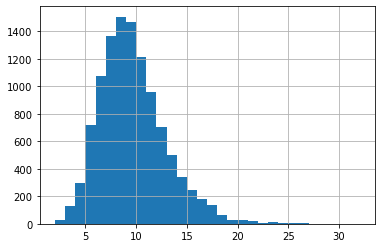

In [8]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
max_seq_len = max(seq_len)
print(max_seq_len)

In [9]:
# tokenize and encode sequences in the training set
if max_seq_len>512:
    max_seq_len = 512
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)



In [10]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
print("train_y:",train_y)
# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
print("val_y:",val_y)


train_y: tensor([2, 2, 5,  ..., 4, 1, 2])
val_y: tensor([2, 5, 6,  ..., 6, 3, 2])


In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [12]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [13]:
class BERT_Arch(nn.Module):
    def __init__(self, bert,label_map):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
      
        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,len(label_map))

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

        #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)
        return x

In [14]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert,label_map)

# push the model to GPU
model = model.to(device)

In [15]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [16]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.99827992 1.00528763 1.00657234 0.98455357 1.01369737 0.98455357
 1.00786034]


In [17]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 30

In [27]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0
  
    # empty list to save model predictions
    total_preds=[]
    total_labels =[]
  
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        # append the model predictions
        total_preds+=list(preds)
        total_labels+=labels.tolist()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    f1 = f1_score(total_labels, total_preds, average='weighted')
    #returns the loss and predictions
    return avg_loss, f1

In [28]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Calculate elapsed time in minutes.
          #elapsed = format_time(time.time() - t0)

          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            total_preds+=list(preds)
            total_labels+=labels.tolist()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    
    f1 = f1_score(total_labels, total_preds, average='weighted')
    return avg_loss, f1

In [20]:
def save_checkpoint(filename, epoch, model, optimizer, label_map, id2label):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'label_map': label_map,
        'id_map':id2label}
    torch.save(state, filename)

In [29]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, f1_train = train()
    
    #evaluate model
    valid_loss, f1_valid = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        file_name = 'topic_saved_weights.pt'
        save_checkpoint(file_name, epoch, model, optimizer, label_map, id2label)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining F1: {f1_train:.3f}')
    print(f'Validation F1: {f1_valid:.3f}')


 Epoch 1 / 30
  Batch   100  of    690.
  Batch   200  of    690.
  Batch   300  of    690.
  Batch   400  of    690.
  Batch   500  of    690.
  Batch   600  of    690.

Evaluating...
  Batch    50  of    173.
  Batch   100  of    173.
  Batch   150  of    173.

Training Loss: 0.391
Validation Loss: 0.243

Training F1: 0.864
Validation F1: 0.916

 Epoch 2 / 30
  Batch   100  of    690.
  Batch   200  of    690.
  Batch   300  of    690.
  Batch   400  of    690.
  Batch   500  of    690.
  Batch   600  of    690.

Evaluating...
  Batch    50  of    173.
  Batch   100  of    173.
  Batch   150  of    173.

Training Loss: 0.375
Validation Loss: 0.375

Training F1: 0.865
Validation F1: 0.857

 Epoch 3 / 30
  Batch   100  of    690.
  Batch   200  of    690.
  Batch   300  of    690.
  Batch   400  of    690.
  Batch   500  of    690.
  Batch   600  of    690.

Evaluating...
  Batch    50  of    173.
  Batch   100  of    173.
  Batch   150  of    173.

Training Loss: 0.360
Validation Los

  Batch   600  of    690.

Evaluating...
  Batch    50  of    173.
  Batch   100  of    173.
  Batch   150  of    173.

Training Loss: 0.261
Validation Loss: 0.146

Training F1: 0.910
Validation F1: 0.952

 Epoch 25 / 30
  Batch   100  of    690.
  Batch   200  of    690.
  Batch   300  of    690.
  Batch   400  of    690.
  Batch   500  of    690.
  Batch   600  of    690.

Evaluating...
  Batch    50  of    173.
  Batch   100  of    173.
  Batch   150  of    173.

Training Loss: 0.260
Validation Loss: 0.152

Training F1: 0.908
Validation F1: 0.948

 Epoch 26 / 30
  Batch   100  of    690.
  Batch   200  of    690.
  Batch   300  of    690.
  Batch   400  of    690.
  Batch   500  of    690.
  Batch   600  of    690.

Evaluating...
  Batch    50  of    173.
  Batch   100  of    173.
  Batch   150  of    173.

Training Loss: 0.257
Validation Loss: 0.178

Training F1: 0.908
Validation F1: 0.939

 Epoch 27 / 30
  Batch   100  of    690.
  Batch   200  of    690.
  Batch   300  of    690.

In [ ]:
path = 'topic_saved_weights.pt'
test_df = ld.validation_data_frame

checkpoint = torch.load(path,map_location=device)
model = checkpoint.get("model")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# tokenize and encode sequences in the test set
test_text,test_labels = test_df["query"],test_df["category"]

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())
print("test_y:",test_y)

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [45]:
class Prediction:
    def __init__(self):
        path = 'topic_saved_weights.pt'

        checkpoint = torch.load(path,map_location=device)
        self.predictor = checkpoint.get("model")
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tag = checkpoint.get("id_map")

    def predict(self,text):
        tokens = self.tokenizer.tokenize(text)
        tokens = tokens[:max_seq_len - 2]
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = input_ids + [0] * (max_seq_len-len(input_ids))
        input_ids = torch.tensor(input_ids).unsqueeze(0)
        input_ids = input_ids.to(device)

        input_mask = [1]*len(tokens) + [0] * (max_seq_len - len(tokens))
        input_mask = torch.tensor(input_mask).unsqueeze(0)
        input_mask = input_mask.to(device)

        logits = self.predictor(input_ids,input_mask)
        prob = torch.nn.functional.softmax(logits,dim=1)
        result = [(self.tag[idx],item *100) for idx,item in enumerate(prob[0].tolist())]
        preds = logits.detach().cpu().numpy()
        pred_val = np.argmax(preds)
        pred_val = self.tag[pred_val]
        return result,pred_val


In [46]:
pred = Prediction()

In [47]:
list_input = ["Play music from my relentless playlist",
             "I rate this essay a four of 6"]

for item in list_input:
    confidence,pred_val = pred.predict(item)
    print(pred_val)
    print(confidence)

PlayMusic
[('BookRestaurant', 1.2048614905779687e-05), ('SearchScreeningEvent', 0.06772816996090114), ('RateBook', 7.69690757351782e-05), ('GetWeather', 7.716318251027587e-07), ('AddToPlaylist', 41.87126159667969), ('PlayMusic', 56.4595103263855), ('SearchCreativeWork', 1.6014140099287033)]
RateBook
[('BookRestaurant', 1.0315424070483914e-06), ('SearchScreeningEvent', 2.932396769850243e-07), ('RateBook', 100.0), ('GetWeather', 8.08519862172119e-08), ('AddToPlaylist', 3.296656814200105e-06), ('PlayMusic', 1.5063672531567818e-08), ('SearchCreativeWork', 1.3556576305973067e-06)]
